# Claim Validation by Fine Tuning Language Model

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
!pip install fastai==0.7.0
!pip install torchtext==0.2.3

In [0]:
from fastai.text import *
import html

In [0]:
import os
DATA_PATH=Path('data/')
DATA_PATH.mkdir(exist_ok=True)
#!curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 
#!tar -C {DATA_PATH} -xvf aclImdb_v1.tar.gz

### First we load the LIAR/FEVER dataset and tokenize it.


In [0]:
import csv
from keras.utils import to_categorical
os.chdir('data/')
!wget https://www.dropbox.com/s/2i9au4qcmjcdmn5/liar_final_train.json && wget https://www.dropbox.com/s/z1ans2eumj5kj1s/liar_final_valid.json && wget https://www.dropbox.com/s/2pb0tyhq9udpilz/liar_final_test.json   
!wget https://www.dropbox.com/s/69cma05v3w4oc8m/liar_train_raw.tsv && wget https://www.dropbox.com/s/lytkzczsgxbzblc/liar_valid_raw.tsv && wget https://www.dropbox.com/s/tsxon4egz7zrw5g/liar_test_raw.tsv
CLASSES = ['pants-fire','false','barely-true','half-true','mostly-true','true']
def checkLabel(label):
  if label == 'pants-fire':
    return 0
  elif label == 'false':
    return 1
  elif label == 'barely-true':
    return 2
  elif label == 'half-true':
    return 3
  elif label == 'mostly-true':
    return 4
  else:
    return 5

def getLiarData(path):  
  dic={}
  label=[]
  claim=[]
  speaker=[]
  job=[]
  party=[]
  evidence=[]
  claim_dic={}
  with open('liar_final_'+path+'.json', 'r') as f:
    dataset = f.read().split('\n')
    dataset = json.loads(dataset[0])

    for i in dataset:
      claim_dic[i["claim"]] = i["evidence"]
      
  with open('liar_'+path+'_raw.tsv') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    for row in reader:
      if len(row) < 14 or row[2] not in list(claim_dic.keys()):
        continue
      label.append(checkLabel(row[1]))
      claim.append((row[2]))  
      speaker.append(row[4])
      job.append(row[5])
      party.append(row[7])
      evidence.append(claim_dic[row[2]])
      
    label = (label) 
    dic['label'] = label
    dic['claim'] = (claim)
    dic['speaker'] = speaker
    dic['job'] = job
    dic['party'] = party
    dic['evidence'] = (evidence)
    return dic
  
  
train = getLiarData('train')
valid = getLiarData('valid')
test = getLiarData('test')

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from sklearn.metrics.pairwise import cosine_similarity
import unicodedata

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

stop = list(set(stopwords.words('english')))
stop.remove('nor')
stop.remove('not')
stop.remove('no')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def strip_accents(text):
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)
  
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
      stemmed.append(stemmer.stem(item))
    return stemmed
def lemmatize_tokens(tokens, lemmatizer):
    lemmatized=[]
    for word, tag in pos_tag(tokens):
      temp = '0'
      if tag.startswith("NN"):
          temp =  lemmatizer.lemmatize(word, pos='n')
      elif tag.startswith('VB'):
          temp = lemmatizer.lemmatize(word, pos='v')
      elif tag.startswith('JJ'):
          temp = lemmatizer.lemmatize(word, pos='a')
      else:
          temp = word
      lemmatized.append(temp)
    return lemmatized

def tokenize(text):
    b = ['-lrb-', '-rrb-', '-rsb-', '-lsb-', '-lcb-', '-rcb-']
    text = text.lower()
    text = re.sub("\'"+'[A-Za-z]*', '', text)
    text = strip_accents(text)
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation and token not in b and token not in stop and len(token)>2 and not token.isdigit()]
    #stems = lemmatize_tokens(tokens, lemmatizer)
    return tokens
  
def preprocess(listt):
    new_list=[]
    for i in listt:
      z = tokenize(i)
      #z = ' '.join(x for x in z)
      new_list.append(z)
    print('Preprocess done.')
    return new_list 
  
def pad_sentence(listt, length):
    new_list = []
    max = 0
    for string in listt:
      if len(string)>max:
        max = len(string)
     
    if length < max:
      max = length
    print("Maximum sequence length: "+str(max))
    for string in listt:
      z = max - len(string)
      if z > 0:
        temp = string + ['<PAD/>']*z
      else:
        temp = string[0:max]
      new_list.append(temp)
    return new_list
  
def build_vocab(sentences):
    word_counts = Counter(itertools.chain(*sentences))
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    print("Length of vocabulary: " + str(len(vocabulary)))
    return [vocabulary, vocabulary_inv]  
  

In [0]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/aclImdb/')

## Standardize format

In [0]:
os.chdir('..')
CLAS_PATH=Path('data/imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

In [0]:
len(train['claim']),len(valid['claim'])

In [0]:
col_names = ['labels','text']

In [0]:
CLASSES = ['neg', 'pos', 'unsup']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)
    return np.array(texts),np.array(labels)

#trn_texts,trn_labels = get_texts(PATH/'train')
#val_texts,val_labels = get_texts(PATH/'test')

We use a random permutation np array to shuffle the claim sentences.

In [0]:
np.random.seed(42)
trn_idx = np.random.permutation(len(train['claim']))
val_idx = np.random.permutation(len(test['claim']))

In [0]:
trn_texts = [train['claim'][i] for i in trn_idx]
val_texts = [test['claim'][i] for i in val_idx]
trn_evidence = [train['evidence'] for i in trn_idx]
trn_profile = [train]

trn_labels = [train['label'][i] for i in trn_idx]
val_labels = [test['label'][i] for i in val_idx]

In [0]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

In [0]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w', encoding='utf-8').writelines(f'{o}\n' for o in CLASSES)

We start by creating the data for the Language Model(LM). The LM's goal is to learn the structure of the english language. It learns language by trying to predict the next word given a set of previous words(ngrams). Since the LM does not classify reviews, the labels can be ignored.


In [0]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts]), test_size=0.1)

In [0]:
len(trn_texts), len(val_texts)

(10346, 1150)

In [0]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

## Language model tokens

In this section, we start cleaning up the messy text. There are 2 main activities we need to perform:

1. Clean up extra spaces, tab chars, new ln chars and other characters and replace them with standard ones
2. Use the awesome [spacy](http://spacy.io) library to tokenize the data. Since spacy does not provide a parallel/multicore version of the tokenizer, the fastai library adds this functionality. This parallel version uses all the cores of your CPUs and runs much faster than the serial version of the spacy tokenizer.

Tokenization is the process of splitting the text into separate tokens so that each token can be assigned a unique index. This means we can convert the text into integer indexes our models can use.

We use an appropriate chunksize as the tokenization process is memory intensive

In [0]:
chunksize=24000

In [0]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [0]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype('int64')
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [0]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [0]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [0]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [0]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [0]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [0]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [0]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

In [0]:
max_vocab = 60000
min_freq = 2

In [0]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our stoi mapping.

In [0]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

5255

In [0]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [0]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [0]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [0]:
vs=len(itos)
vs,len(trn_lm)

(5255, 10346)

## wikitext103 conversion

In [0]:
!wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

In [0]:
em_sz,nh,nl = 400,1150,3

In [0]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [0]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [0]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [0]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [0]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [0]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [0]:
wgts.keys()

odict_keys(['0.encoder.weight', '0.encoder_with_dropout.embed.weight', '0.rnns.0.module.weight_ih_l0', '0.rnns.0.module.bias_ih_l0', '0.rnns.0.module.bias_hh_l0', '0.rnns.0.module.weight_hh_l0_raw', '0.rnns.1.module.weight_ih_l0', '0.rnns.1.module.bias_ih_l0', '0.rnns.1.module.bias_hh_l0', '0.rnns.1.module.weight_hh_l0_raw', '0.rnns.2.module.weight_ih_l0', '0.rnns.2.module.bias_ih_l0', '0.rnns.2.module.bias_hh_l0', '0.rnns.2.module.weight_hh_l0_raw', '1.decoder.weight'])

Now that we have the weights prepared, we are ready to create and start training our new LIAR language pytorch model!

## Language model

In [0]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [0]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

In [0]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [0]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [0]:
learner.model.load_state_dict(wgts)

In [0]:
lr=1e-3
lrs = lr

In [0]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      5.041947   4.765958   0.260694  



[array([4.76596]), 0.26069418497201874]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [0]:
learner.save('lm_last_ft')

In [0]:
learner.load('lm_last_ft')

In [0]:
learner.unfreeze()

In [0]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy   
    0      3.710196   3.448036   0.390779  



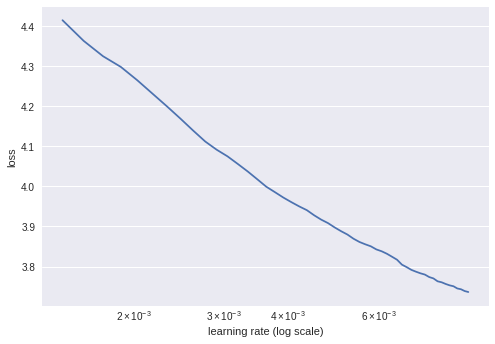

In [0]:
learner.sched.plot()

In [0]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=5)

epoch      trn_loss   val_loss   accuracy   
    0      3.817415   3.424528   0.397984  
    1      3.502419   3.321607   0.407701  
    2      3.30045    3.277002   0.414106  
    3      3.142319   3.255029   0.415947  
    4      3.045286   3.253472   0.416726  



[array([3.25347]), 0.41672588509720415]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [0]:
learner.save('lm1')

In [0]:
learner.save_encoder('lm1_enc')

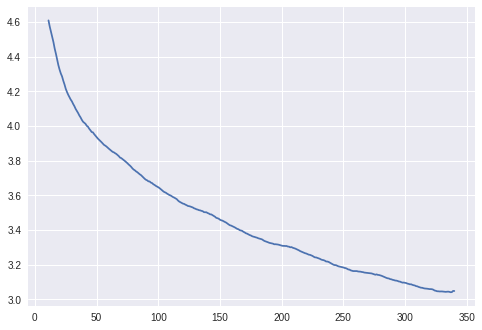

In [0]:
learner.sched.plot_loss()

## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time.

In [0]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [0]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [0]:
tok_trn

[['\n',
  'xbos',
  'xfld',
  '1',
  '25,000',
  'businesses',
  'have',
  'been',
  'created',
  'since',
  '(',
  'scott',
  ')',
  'walker',
  'took',
  'office',
  '.'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  'says',
  'cory',
  'booker',
  'supports',
  'late',
  '-',
  'term',
  'and',
  'partial',
  '-',
  'birth',
  'abortion',
  'and',
  'opposes',
  'safety',
  'regulations',
  '.'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  'says',
  'health',
  'insurance',
  'premiums',
  'will',
  'rise',
  'under',
  'obamacare',
  '.'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  'when',
  'he',
  'took',
  'office',
  'in',
  '2009',
  ',',
  'president',
  'barack',
  'obama',
  'had',
  'the',
  'biggest',
  'democratic',
  'majorities',
  'in',
  'congress',
  'since',
  'lyndon',
  'johnson',
  '.'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  'under',
  'scott',
  'walkers',
  'policies',
  ',',
  'the',
  'typical',
  'wisconsin',
  'family',
  'has',
  'actually',
  'seen',
  'their',
  'real',
  'i

In [0]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [0]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [0]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

5255

In [0]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [0]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained LIAR backbone. The steps to create the classifier model are similar to the ones for the LM.

In [0]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [0]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [0]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [0]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1
#c=6

In the classifier, unlike LM, we need to read a movie review at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie reviews, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [0]:
ls data/aclImdb/models

lm1_enc.h5  lm1.h5  lm_last_ft.h5  tmp.h5  wt103/


In [0]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1)
md = ModelData(PATH, trn_dl, val_dl, val_dl )

In [0]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1]) 

In [0]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.65

In [0]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [0]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [0]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

In [0]:
lr=(3e-3)*10
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [0]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [0]:
wd = 1e-7
#wd = 0
learn.load_encoder('lm1_enc')

In [0]:
learn.freeze_to(-1)

 85%|████████▍ | 361/427 [00:32<00:06, 10.71it/s, loss=7.45]

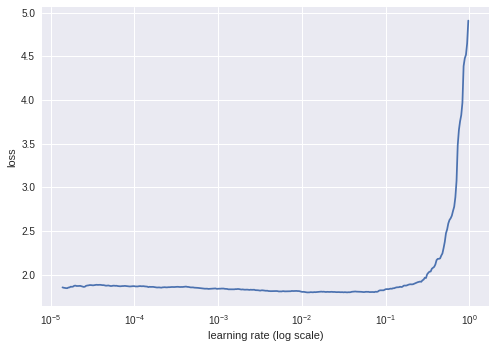

In [0]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [0]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy   
    0      1.736024   1.70755    0.249991  


[array([1.71]), 0.24999105312967115]

In [0]:
learn.freeze_to(-2)

In [0]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy   
    0      1.720961   1.685272   0.257463  


[array([1.69]), 0.2574634909489003]

In [0]:
learn.unfreeze()

In [0]:
class SaveBestModel(LossRecorder):
    def __init__(self, model, lr, name='best_model'):
        super().__init__(model.get_layer_opt(lr, None))
        self.name = name
        self.model = model
        self.best_loss = None
        self.best_acc = None

    def on_epoch_end(self, metrics):
        super().on_epoch_end(metrics)
        (loss), (acc) = metrics
        if self.best_acc == None or acc > self.best_acc:
            self.best_acc = acc
            self.best_loss = loss
            self.model.save(f'{self.name}')
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.model.save(f'{self.name}')
        print(self.best_loss, self.best_acc)    
cb = SaveBestModel(learn, lr, name='bestt')

In [0]:
#rm data/aclImdb/models/best.h5

In [0]:
learn.fit(lrs, 1, wds=wd, cycle_len=6, use_clr=(32,10), callbacks=[cb])

0.292259083728278
              precision    recall  f1-score   support

  pants-fire       0.34      0.20      0.25        92
       false       0.33      0.42      0.37       249
 barely-true       0.25      0.23      0.24       212
   half-true       0.27      0.29      0.28       265
 mostly-true       0.28      0.30      0.29       240
        true       0.31      0.24      0.27       208

   micro avg       0.29      0.29      0.29      1266
   macro avg       0.30      0.28      0.28      1266
weighted avg       0.29      0.29      0.29      1266

Confusion matrix, without normalization
[[ 18  27  18  10  13   6]
 [ 10 104  33  39  39  24]
 [  8  48  49  58  32  17]
 [  5  61  42  77  53  27]
 [  6  35  35  57  73  34]
 [  6  40  22  44  47  49]]
Normalized confusion matrix
[[0.2  0.29 0.2  0.11 0.14 0.07]
 [0.04 0.42 0.13 0.16 0.16 0.1 ]
 [0.04 0.23 0.23 0.27 0.15 0.08]
 [0.02 0.23 0.16 0.29 0.2  0.1 ]
 [0.03 0.15 0.15 0.24 0.3  0.14]
 [0.03 0.19 0.11 0.21 0.23 0.24]]


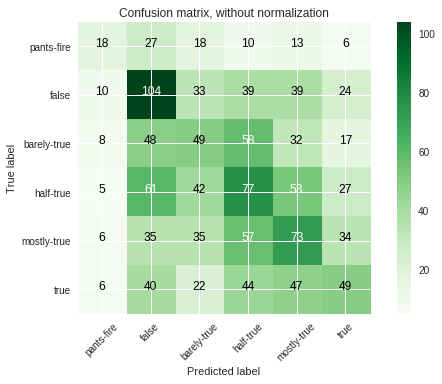

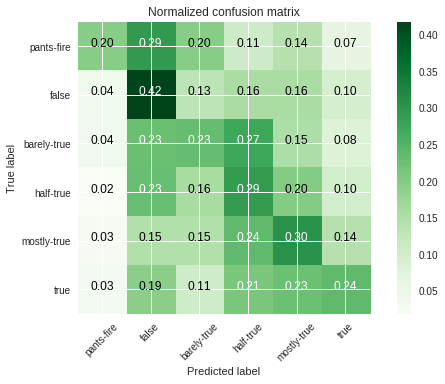

In [0]:
pred = learn.predict()
pred = np.argmax(pred, axis=1)
getTestScore(val_labels, pred)

In [0]:
import pickle
with open('val_labels.pickle', 'wb') as handle:
    pickle.dump(val_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

drive_service = build('drive', 'v3')
file_metadata = {
  'name': 'val_labels.pickle',
  'mimeType': 'application/octet-stream'
}
media = MediaFileUpload('val_labels.pickle', 
                        mimetype='application/octet-stream',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id'))) 

File ID: 1w3LDpNiYC8Zr4H8rMApGvwEbxKS_6EVu


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
def getTestScore(Y_test, pred):
  print(accuracy_score(Y_test, pred))
  target_names = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true','true']
  print(classification_report(Y_test, pred, target_names=target_names))
  # Compute confusion matrix
  cnf_matrix = confusion_matrix(Y_test, pred)
  np.set_printoptions(precision=2)

  # Plot non-normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=target_names,
                        title='Confusion matrix, without normalization')

  # Plot normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                        title='Normalized confusion matrix')

  plt.show()
  return

In [0]:
learn.sched.plot_loss()

In [0]:
learn.save('clas_2')